In [1]:
from pathlib import Path

import papermill as pm

import numpy as np
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt

from centrex_tlf import transitions, utils, hamiltonian

In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
template = "papermill template amherst multipass.ipynb"

trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=3 / 2, F=1
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=3 / 2, F=2
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=5 / 2, F=2
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=1, F1=5 / 2, F=3
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=0
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=1
    ),
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=3 / 2, F=1
    ),
]


In [4]:
laser_power = 23.8e-3  # power in W
σlaser = 0.000914
npasses = 9
multipass_offset = 0.01
distance_between_passes = 0.03556 / npasses
power_loss_per_pass = 20.2 / 23.8

vcm = 150.0
vcm_sigma = 30.0
vperp_sigma = 38.0

ωp = 0.65 * hamiltonian.Γ

β = 3.8
ωphase = 0.0

δ_range = [1.6, -1.5, 22]  # logspace
vz_range = [80, 250, 15]  # linspace
y0_range = [-0.002, 0.002, 11]  # linspace

nprocs = 7

In [5]:
for tr in trans:
    print(tr.name)
    pm.execute_notebook(
        template,
        tr.name.replace("'", "").replace("/", "_") + ".ipynb",
        parameters=dict(
            transition_type=tr.t.name,
            J_ground=tr.J_ground,
            F1_excited=tr.F1,
            F_excited=tr.F,
            laser_power=laser_power,
            σlaser=σlaser,
            npasses=npasses,
            multipass_offset=multipass_offset,
            distance_between_passes=distance_between_passes,
            power_loss_per_pass=power_loss_per_pass,
            vcm=vcm,
            vcm_sigma=vcm_sigma,
            vperp_sigma=vperp_sigma,
            ωp=ωp,
            β=β,
            ωphase=ωphase,
            δ_range=δ_range,
            vz_range=vz_range,
            y0_range=y0_range,
            nprocs=nprocs,
        ),
    )

R(1) F1'=3/2 F'=1


Executing:   0%|          | 0/33 [00:00<?, ?cell/s]

R(1) F1'=3/2 F'=2


Executing:   0%|          | 0/33 [00:00<?, ?cell/s]

R(1) F1'=5/2 F'=2


Executing:   0%|          | 0/33 [00:00<?, ?cell/s]

R(1) F1'=5/2 F'=3


Executing:   0%|          | 0/33 [00:00<?, ?cell/s]

Q(1) F1'=1/2 F'=0


Executing:   0%|          | 0/33 [00:00<?, ?cell/s]

Q(1) F1'=1/2 F'=1


Executing:   0%|          | 0/33 [00:00<?, ?cell/s]

Q(1) F1'=3/2 F'=1


Executing:   0%|          | 0/33 [00:00<?, ?cell/s]

In [6]:
data = {}
for fname in Path().cwd().glob("*.npz"):
    dat = np.load(fname)
    name = fname.stem.strip("results").replace("=", "'=").replace("_", "/").strip(" ")
    data[name] = dict([(f, dat[f]) for f in dat.files])

for tr, dat in data.items():
    scan_values = [dat["vz"], dat["δ"], dat["y0"]]
    data[tr]["interpolator"] = interpolate.RegularGridInterpolator(
        points=scan_values,
        values=dat["results"],
        method="linear",
        bounds_error=False,
        fill_value=np.nan,
    )

In [7]:
data_branching = {}
for fname in Path().cwd().glob("*.csv"):
    name = fname.stem.strip("branching").replace("=", "'=").replace("_", "/").strip(" ")
    df = pd.read_csv(fname, delimiter=",")
    data_branching[name] = df

In [8]:
def generate_random_longitudinal_velocities(n, vμ, vσ):
    """generate random longitudinal velocities

    Args:
        n (int): number of velocities to genrate
        vμ (float): mean velocity
        vσ (float): σ velocity width

    Returns:
        np.ndarray: 1D array with longitudinal velocities
    """
    return np.random.normal(vμ, vσ, n)


def generate_random_transverse_velocities(n, vσ):
    """generate random transverse velocities

    Args:
        n (int): number of velocities to generate
        vσ (float): σ width of transverse velocity distribution

    Returns:
        np.ndarray: 2D array with transverse velocities
    """
    velocities = np.random.multivariate_normal(
        [0, 0], np.array([[vσ**2, 0], [0, vσ**2]]), n
    ).T
    return velocities


def generate_random_coords_circle_2D(n, σ):
    """generate random xy coordinates in a circle

    Args:
        n (int): number of coordinates to generate
        σ (float): σ width of circle to generate coordinates in

    Returns:
        np.ndarray: 2D array with xy coordinates
    """

    def generate_random_r(n, σ):
        return np.random.normal(0, σ, n)

    xy = np.empty([2, n])
    xy[0, :] = generate_random_r(n, σ)
    xy[1, :] = generate_random_r(n, σ)
    return xy

In [9]:
n = int(1e7)
vz = generate_random_longitudinal_velocities(n, vcm, vcm_sigma)
vx, vy = generate_random_transverse_velocities(n, vperp_sigma)
x0, y0 = generate_random_coords_circle_2D(n, 0.0025)
apertures = [(47e-3, 6.35e-3), (73e-3, 12.7e-3), (290e-3, 2.54e-3)]
mask = np.ones(n, dtype=bool)
for location, diameter in apertures:
    t = location / vz
    r = np.sqrt((x0 + vx * t) ** 2 + (y0 + vy * t) ** 2)
    m = r < diameter / 2
    mask &= m

In [15]:
δs = np.linspace(-65, 65, 101) * 2 * np.pi * 1e6
δl_vx = utils.detuning.velocity_to_detuning(vx[mask])

In [16]:
detuning_scans = {}
for tr, dat in data.items():
    detuning_scans[tr] = np.array(
        [
            np.nanmean(dat["interpolator"](np.array([vz[mask], δl_vx + δ, y0[mask]]).T))
            for δ in δs
        ]
    )

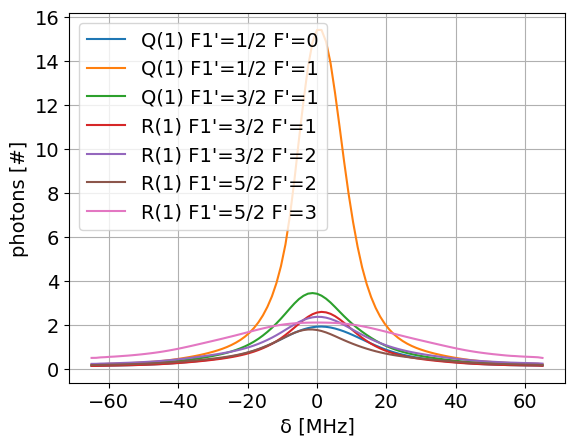

In [17]:
fig, ax = plt.subplots()

for tr, scan in detuning_scans.items():
    ax.plot(δs / (2 * np.pi * 1e6), scan, label=tr)

ax.set_xlabel("δ [MHz]")
ax.set_ylabel("photons [#]")

ax.legend()
ax.grid()


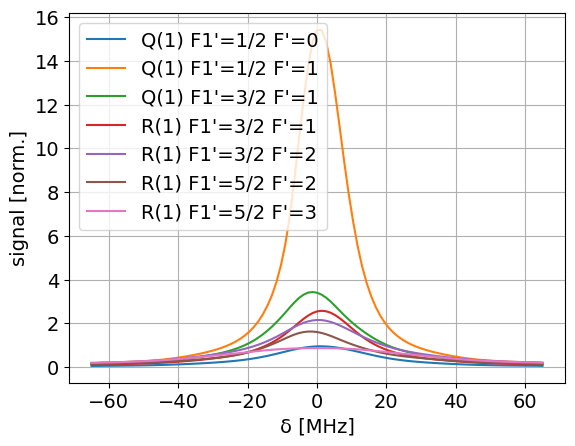

In [18]:
total_levels = utils.population.J_levels(1)

fig, ax = plt.subplots()

for (tr, scan), dat in zip(detuning_scans.items(), data.values()):
    total_coupled = dat["indices_coupled"].size
    ax.plot(δs / (2 * np.pi * 1e6), scan * total_coupled / total_levels, label=tr)

ax.set_xlabel("δ [MHz]")
ax.set_ylabel("signal [norm.]")

ax.legend()
ax.grid()


In [19]:
dataframe_data = {
    "name": [],
    "photons branching": [],
    "photons simulated": [],
    "signal": [],
    "ratio coupled/total": [],
    "levels coupled": [],
    "total levels": [],
}
for (tr, scan), dat in zip(detuning_scans.items(), data.values()):
    total_coupled = dat["indices_coupled"].size
    total_levels = utils.population.J_levels(1)
    photons_branching = 1 / (1 - np.array(data_branching[tr].iloc[0])[-1])
    signal = scan.max() * total_coupled / total_levels
    dataframe_data["name"].append(tr)
    dataframe_data["photons branching"].append(photons_branching)
    dataframe_data["photons simulated"].append(scan.max())
    dataframe_data["signal"].append(signal)
    dataframe_data["ratio coupled/total"].append(total_coupled / total_levels)
    dataframe_data["levels coupled"].append(total_coupled)
    dataframe_data["total levels"].append(total_levels)

df = pd.DataFrame(dataframe_data)
df.set_index("name")
df.signal /= df.signal.max()
df

C:\Users\ogras\AppData\Local\Temp\ipykernel_21744\573287277.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  photons_branching = 1 / (1 - np.array(data_branching[tr].iloc[0])[-1])


,name,photons branching,photons simulated,signal,ratio coupled/total,levels coupled,total levels
0,Q(1) F1'=1/2 F'=0,inf,1.912491,0.062049,0.500000,6,12
1,Q(1) F1'=1/2 F'=1,7895.689048,15.411088,1.000000,1.000000,12,12
2,Q(1) F1'=3/2 F'=1,9.149942,3.435910,0.222951,1.000000,12,12
3,R(1) F1'=3/2 F'=1,3.441357,2.579831,0.167401,1.000000,12,12
4,R(1) F1'=3/2 F'=2,3.470484,2.355191,0.140089,0.916667,11,12
5,R(1) F1'=5/2 F'=2,2.105296,1.779060,0.105820,0.916667,11,12
6,R(1) F1'=5/2 F'=3,2.098773,2.095164,0.056647,0.416667,5,12
